Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   timestamp       2644 non-null   int64         
 1   value           2644 non-null   int64         
 2   classification  2644 non-null   object        
 3   date            2644 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 82.8+ KB
None
First 5 rows:
    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15   Extreme Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
3  1517722200     24   Extreme Fear 2018-02-04
4  1517808600     11   Extreme Fear 2018-02-05
Sentiment classification counts:
classification
Fear             781

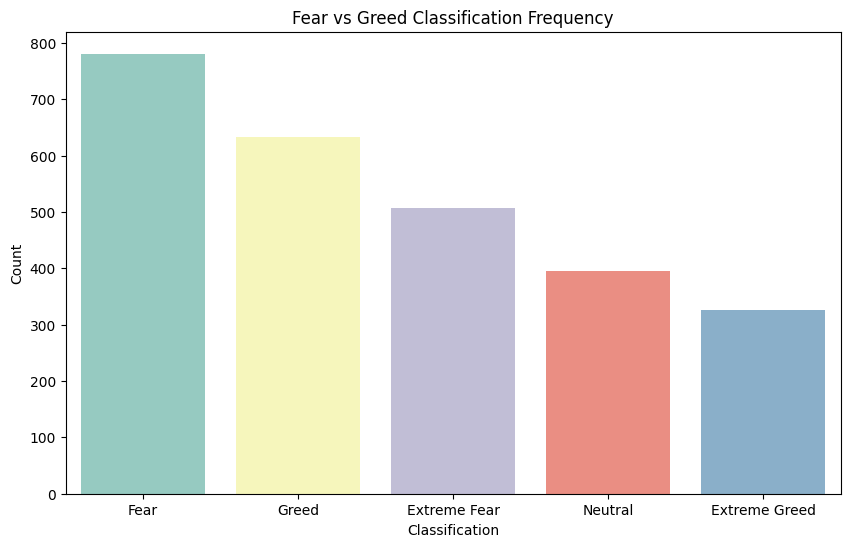

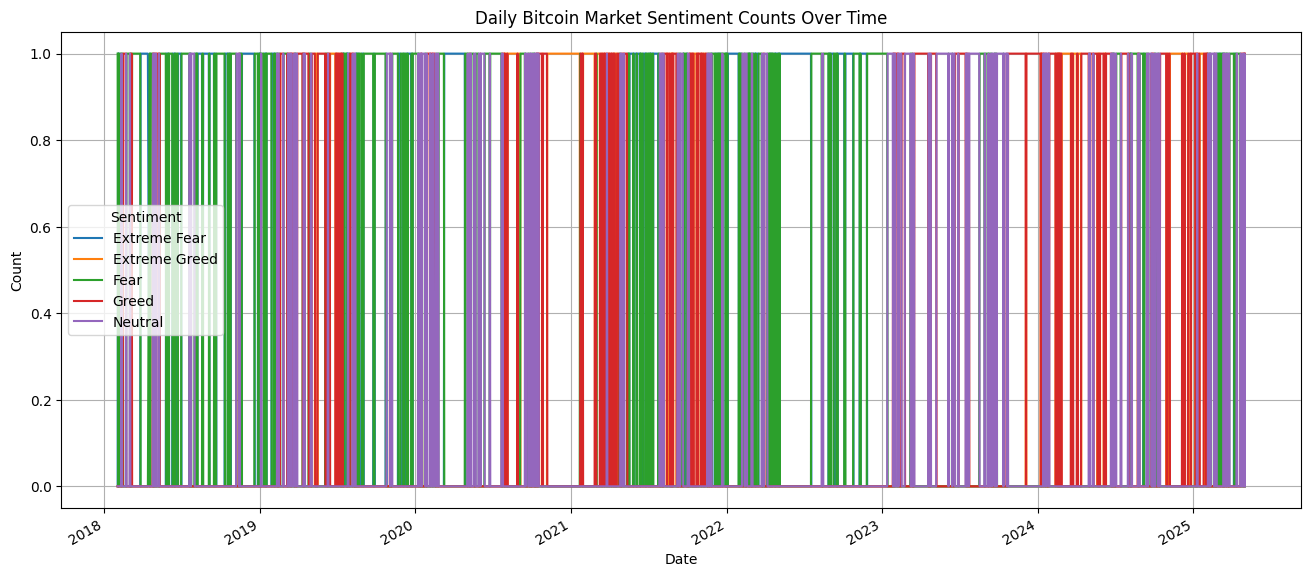

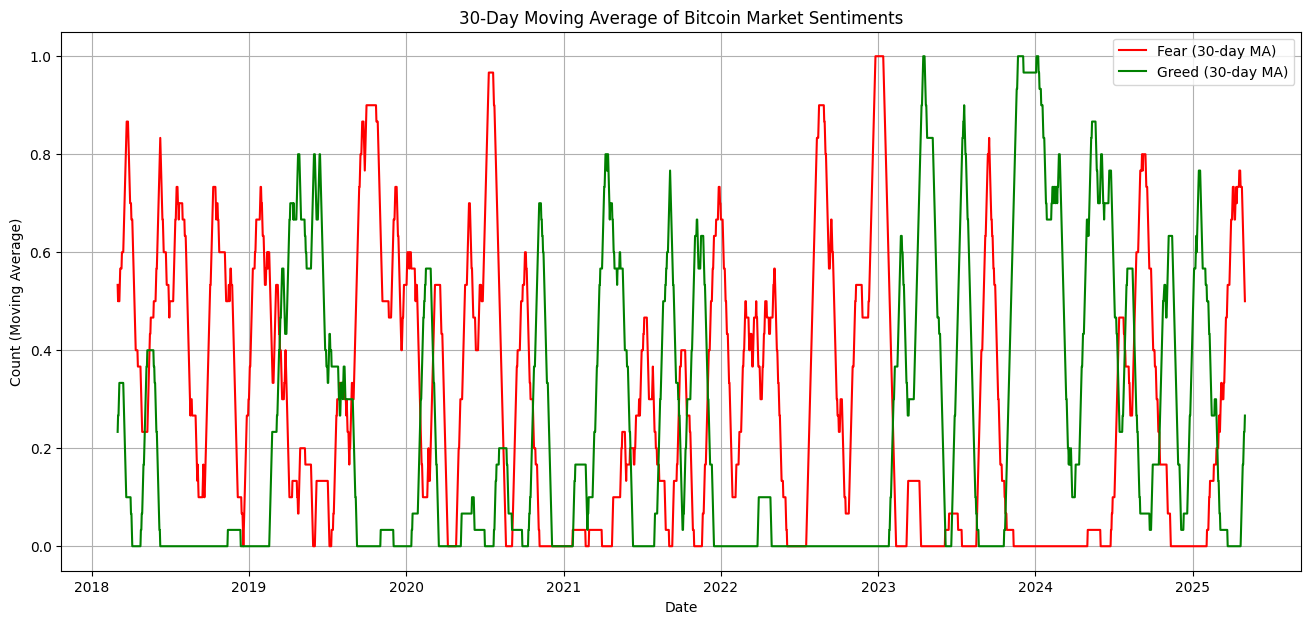

Longest streaks for each sentiment:
classification
Extreme Fear     74
Extreme Greed    77
Fear             48
Greed            42
Neutral          28
Name: classification, dtype: int64


In [3]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive')
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/ds_afisar_alam/csv_files/fear_greed_index .csv')

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with missing values in critical columns
df = df.dropna(subset=['date', 'classification']).reset_index(drop=True)

# Sort dataframe by date
df = df.sort_values('date')

# Basic data info and first few rows
print("Dataset info:")
print(df.info())
print("First 5 rows:")
print(df.head())

# Sentiment distribution counts
sentiment_counts = df['classification'].value_counts()
print("Sentiment classification counts:")
print(sentiment_counts)

# Create 'outputs' directory
output_dir = 'outputs'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# Plot 1: Sentiment classification frequency bar chart
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='classification', order=sentiment_counts.index, palette='Set3')
plt.title('Fear vs Greed Classification Frequency')
plt.xlabel('Classification')
plt.ylabel('Count')
plt.savefig('outputs/sentiment_classification_count.png')
plt.show()

# Prepare daily counts of sentiment
daily_counts = df.groupby(['date', 'classification']).size().unstack(fill_value=0)

# Plot 2: Time series of daily sentiment counts
plt.figure(figsize=(16,7))
daily_counts.plot(ax=plt.gca())
plt.title('Daily Bitcoin Market Sentiment Counts Over Time')
plt.ylabel('Count')
plt.xlabel('Date')
plt.grid(True)
plt.legend(title='Sentiment')
plt.savefig('outputs/daily_sentiment_time_series.png')
plt.show()

# Calculate 30-day rolling average for smoothing
rolling_window = 30
fear_rolling_avg = daily_counts['Fear'].rolling(rolling_window).mean()
greed_rolling_avg = daily_counts['Greed'].rolling(rolling_window).mean()

# Plot 3: 30-day rolling average of Fear and Greed sentiment counts
plt.figure(figsize=(16,7))
plt.plot(fear_rolling_avg.index, fear_rolling_avg.values, label='Fear (30-day MA)', color='red')
plt.plot(greed_rolling_avg.index, greed_rolling_avg.values, label='Greed (30-day MA)', color='green')
plt.title('30-Day Moving Average of Bitcoin Market Sentiments')
plt.xlabel('Date')
plt.ylabel('Count (Moving Average)')
plt.legend()
plt.grid(True)
plt.savefig('outputs/sentiment_30day_moving_avg.png')
plt.show()

# Function to find longest streaks of a sentiment
def find_longest_streaks(sentiment_series):
    streak_id = (sentiment_series != sentiment_series.shift()).cumsum()
    streak_lengths = sentiment_series.groupby([sentiment_series, streak_id]).size()
    longest_streak = streak_lengths.groupby(level=0).max()
    return longest_streak

# Longest streak calculation
longest_streaks = find_longest_streaks(df['classification'])
print("Longest streaks for each sentiment:")
print(longest_streaks)

# summary report
with open('outputs/summary_report.txt', 'w') as f:
    f.write("Bitcoin Market Sentiment Data Analysis Report\n")
    f.write("==============================================\n\n")
    f.write(f"Total records analyzed: {len(df)}\n")
    f.write('\nSentiment Distribution:\n')
    for sentiment, count in sentiment_counts.items():
        f.write(f"- {sentiment}: {count} days\n")
    f.write('\nLongest Consecutive Streaks:\n')
    for sentiment, streak in longest_streaks.items():
        f.write(f"- {sentiment}: {streak} days\n")
    f.write('\nInsights:\n')
    f.write("1. The data shows fluctuations between Fear and Greed sentiments over time.\n")
    f.write("2. Rolling averages help identify smoothed trends for market behavior.\n")
    f.write("3. Longer streaks of Fear may indicate prolonged market uncertainty or downturns.\n")
    f.write("4. Greed streaks often precede market rallies or bubbles.\n")
    f.write("5. Visualization aids in understanding sentiment transitions and cyclicity.\n")

Mounted at /content/drive
Columns after loading CSV: Index(['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side',
       'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL',
       'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID',
       'Timestamp'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79225 entries, 0 to 79224
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Account           79225 non-null  object        
 1   Coin              79225 non-null  object        
 2   Execution Price   79225 non-null  float64       
 3   Size Tokens       79225 non-null  float64       
 4   Size USD          79225 non-null  float64       
 5   Side              79225 non-null  object        
 6   Timestamp IST     79225 non-null  datetime64[ns]
 7   Start Position    79225 non-null  float64       
 8   Direction         79225 non-null

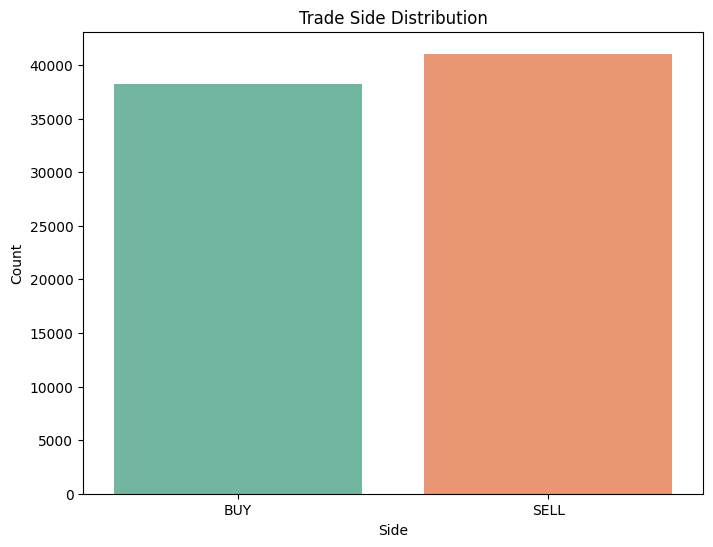

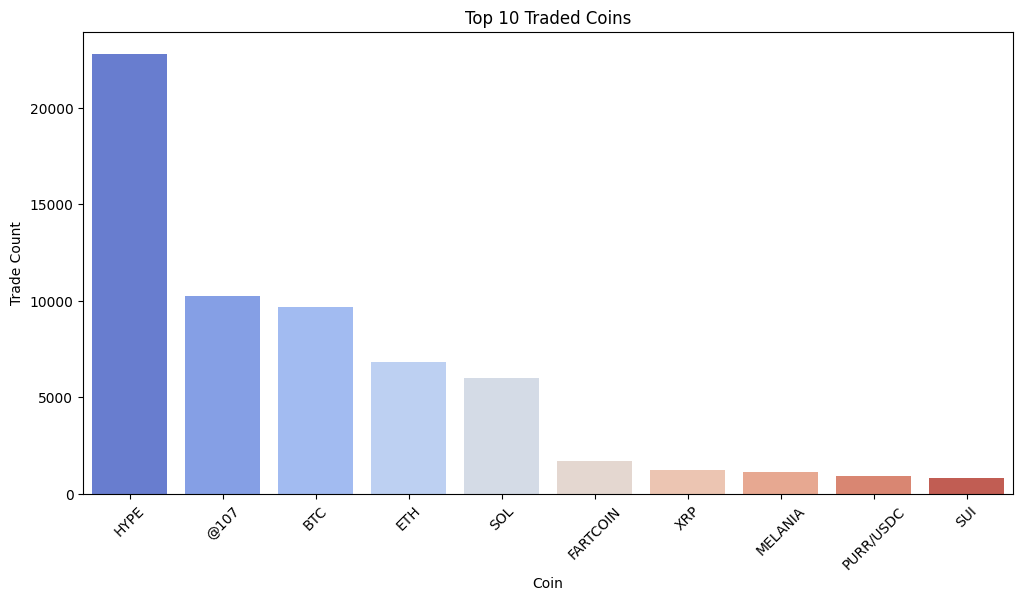

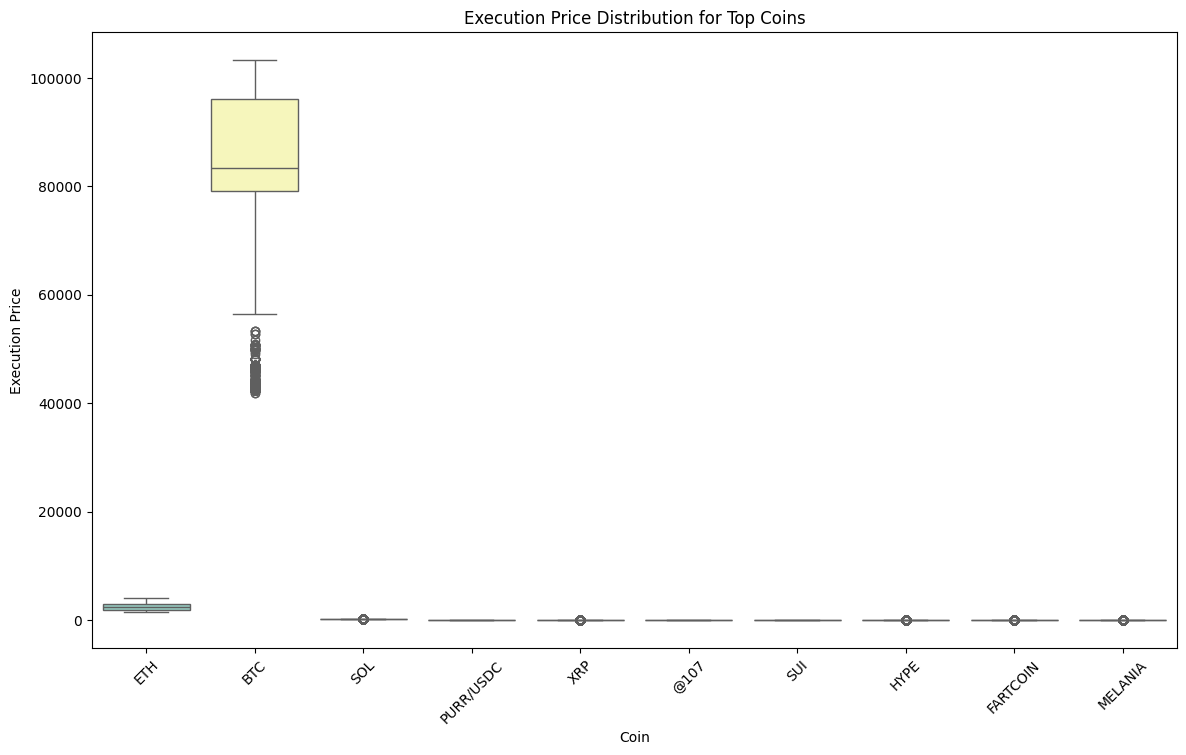

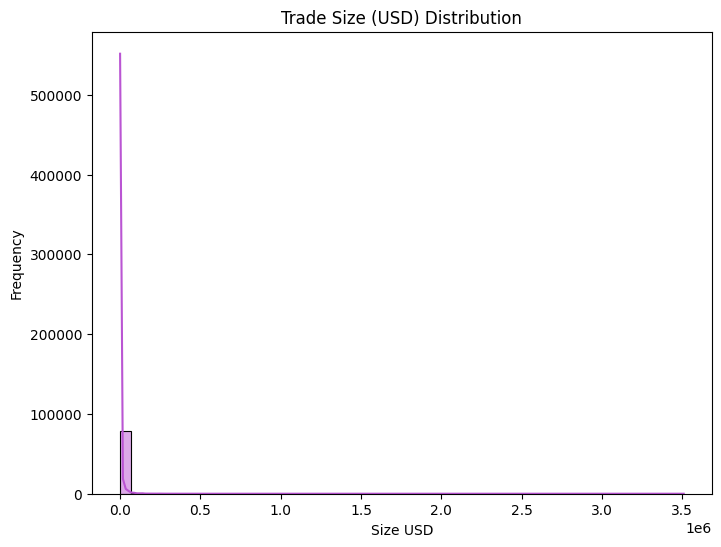

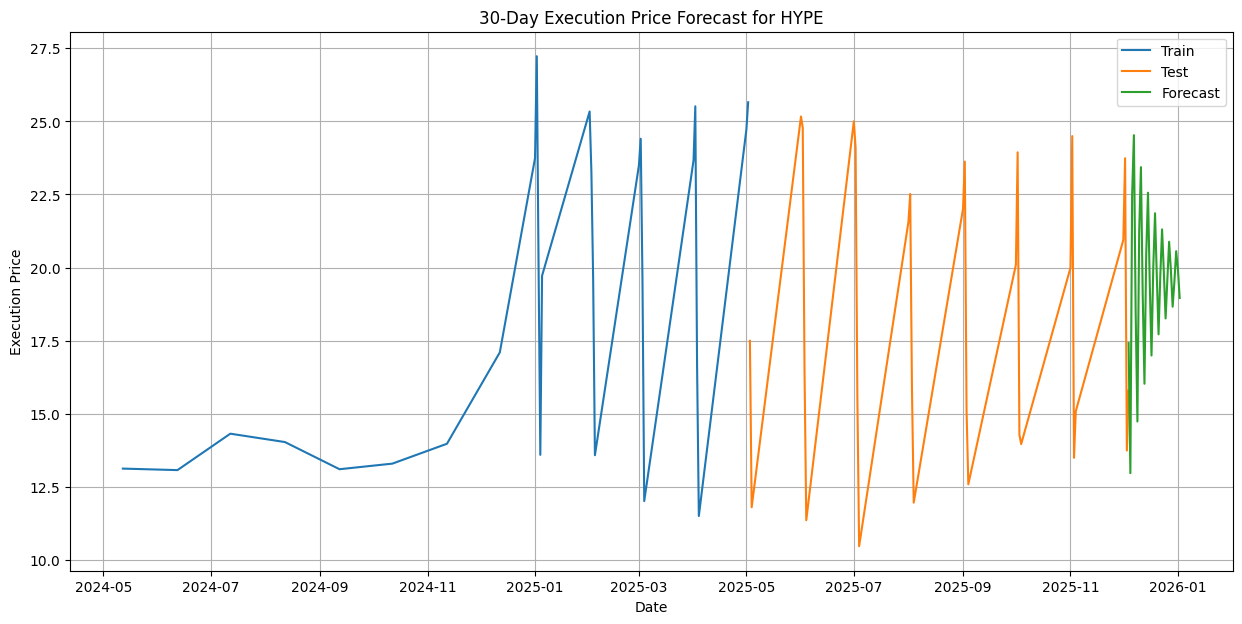

RMSE: 3.4688185451945657


In [5]:
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import os


if not os.path.exists('outputs'):
    os.makedirs('outputs')


# Load the CSV
df = pd.read_csv('/content/drive/MyDrive/ds_afisar_alam/csv_files/historical_data .csv')


# Print column names
print("Columns after loading CSV:", df.columns)


# Convert 'Timestamp IST' to datetime
df['Timestamp IST'] = pd.to_datetime(df['Timestamp IST'], errors='coerce')


# Convert 'Execution Price' to numeric, coercing errors
df['Execution Price'] = pd.to_numeric(df['Execution Price'], errors='coerce')


# Convert 'Size USD' to numeric, coercing errors
df['Size USD'] = pd.to_numeric(df['Size USD'], errors='coerce')



# Drop rows with missing critical columns
df = df.dropna(subset=['Timestamp IST', 'Account', 'Coin', 'Execution Price', 'Side', 'Size USD'])


# Sort data by time
df = df.sort_values('Timestamp IST').reset_index(drop=True)


# Basic info and head
print(df.info())
print(df.head())


# Visualize Trade Side Distribution
plt.figure(figsize=(8,6))
sns.countplot(x='Side', data=df, palette='Set2')
plt.title('Trade Side Distribution')
plt.xlabel('Side')
plt.ylabel('Count')
plt.savefig('outputs/trade_side_distribution.png')
plt.show()


# Top 10 traded Coins
top_coins = df['Coin'].value_counts().head(10)
plt.figure(figsize=(12,6))
sns.barplot(x=top_coins.index, y=top_coins.values, palette='coolwarm')
plt.title('Top 10 Traded Coins')
plt.xlabel('Coin')
plt.ylabel('Trade Count')
plt.xticks(rotation=45)
plt.savefig('outputs/top_traded_coins.png')
plt.show()


# Execution Price Distribution for Top Coins
plt.figure(figsize=(14,8))
sns.boxplot(x='Coin', y='Execution Price', data=df[df['Coin'].isin(top_coins.index)], palette='Set3')
plt.title('Execution Price Distribution for Top Coins')
plt.xticks(rotation=45)
plt.savefig('outputs/execution_price_distribution.png')
plt.show()


# Distribution of Trade Size in USD
plt.figure(figsize=(8,6))
sns.histplot(df['Size USD'].dropna(), bins=50, kde=True, color='mediumorchid')
plt.title('Trade Size (USD) Distribution')
plt.xlabel('Size USD')
plt.ylabel('Frequency')
plt.savefig('outputs/trade_size_usd_distribution.png')
plt.show()


# Time Series Forecasting for Execution Price of Top Coin
selected_coin = top_coins.index[0]
coin_df = df[df['Coin'] == selected_coin].copy()


# Aggregate Execution Price by date
coin_df['Date'] = coin_df['Timestamp IST'].dt.date
daily_exec_price = coin_df.groupby('Date')['Execution Price'].mean()


# Train-test split last 30 days
train_data = daily_exec_price[:-30]
test_data = daily_exec_price[-30:]


# Fit ARIMA model
model = ARIMA(train_data, order=(5,1,0))
model_fit = model.fit()


# Forecast next 30 days
forecast = model_fit.forecast(steps=30)
forecast_dates = pd.date_range(start=test_data.index[-1], periods=30, freq='D')


# Plot actual vs forecast
plt.figure(figsize=(15,7))
plt.plot(train_data.index, train_data, label='Train')
plt.plot(test_data.index, test_data, label='Test')
plt.plot(forecast_dates, forecast, label='Forecast')
plt.title(f'30-Day Execution Price Forecast for {selected_coin}')
plt.xlabel('Date')
plt.ylabel('Execution Price')
plt.legend()
plt.grid(True)
plt.savefig('outputs/arima_execution_price_forecast.png')
plt.show()


# Calculate RMSE
predicted_test = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) -1, typ='levels')
rmse = np.sqrt(mean_squared_error(test_data, predicted_test))
print(f'RMSE: {rmse}')


# Summary Report
with open('outputs/trader_data_summary.txt', 'w') as f:
    f.write('Historical Trader Data Analysis Report\n')
    f.write('=====================================\n')
    f.write(f'Total Records: {len(df)}\n')
    f.write('Trade Side Distribution:\n')
    f.write(f'Buy: {len(df[df["Side"] == "Buy"])}\n')
    f.write(f'Sell: {len(df[df["Side"] == "Sell"])}\n\n')
    f.write('Top 10 Traded Coins:\n')
    for coin, count in top_coins.items():
        f.write(f'{coin}: {count}\n')
    f.write(f'\nForecasting:\n')
    f.write(f'Model: ARIMA(5,1,0)\n')
    f.write(f'RMSE on Test Data: {rmse}\n')